In [1]:
# RAG APP for End Time Message

import getpass
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Set up Langsmith for tracing
print("Application started \n")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_ENDPOINT"] = "https://eu.api.smith.langchain.com"
os.environ['USER_AGENT'] = 'MESSAGE_RAG_APP_AGENT'
if not os.environ.get("LANGSMITH_API_KEY"):
    os.environ["LANGSMITH_API_KEY"] = getpass.getpass()

Application started 



In [2]:
# Set up chat model
if not os.environ.get("GOOGLE_API_KEY"):
  os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter API key for Google Gemini: ")

from langchain.chat_models import init_chat_model

llm = init_chat_model("gemini-2.0-flash", model_provider="google_genai")

In [3]:
# Set up embeddings model

if not os.environ.get("GOOGLE_API_KEY"):
  os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter API key for Google Gemini: ")

from langchain_google_genai import GoogleGenerativeAIEmbeddings

embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

In [4]:
from langchain_mongodb import MongoDBAtlasVectorSearch
from pymongo import MongoClient
import getpass
import os

# Set up MongoDB connection
if not os.environ.get("MONGODB_URI"):
    os.environ["MONGODB_URI"] = getpass.getpass("Enter your MongoDB connection string: ")

if not os.environ.get("MONGODB_DATABASE"):
    os.environ["MONGODB_DATABASE"] = getpass.getpass("Enter your MongoDB database name: ")

if not os.environ.get("MONGODB_COLLECTION"):
    os.environ["MONGODB_COLLECTION"] = getpass.getpass("Enter your MongoDB collection name: ")

if not os.environ.get("ATLAS_VECTOR_SEARCH_INDEX_NAME"):
    os.environ["ATLAS_VECTOR_SEARCH_INDEX_NAME"] = getpass.getpass("Enter your MongoDB vector search index name: ")

# Initialize MongoDB client
client = MongoClient(os.environ.get("MONGODB_URI"))
db = client[os.environ.get("MONGODB_DATABASE")]
collection = db[os.environ.get("MONGODB_COLLECTION")]

# Set up vector store
vector_store = MongoDBAtlasVectorSearch(
    embedding=embeddings,
    collection=collection,  # Pass the collection object, not a string
    index_name=os.environ.get("ATLAS_VECTOR_SEARCH_INDEX_NAME"),
    relevance_score_fn="cosine",
)

In [5]:
from typing import Literal

import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import Annotated, List, TypedDict
from langchain_core.tools import tool
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode
from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import MessagesState, StateGraph
from langgraph.checkpoint.memory import MemorySaver

import sys
from pathlib import Path

# Add project root to Python path
project_root = Path().resolve().parent
sys.path.append(str(project_root))
from src.document_utilities import find_all_pdfs, load_documents
from src.db_utilities import get_distinct_filenames


# Load and chunk contents of the sermons
exclude = get_distinct_filenames(os.environ.get("MONGODB_URI"), os.environ.get("MONGODB_DATABASE"), os.environ.get("MONGODB_COLLECTION"))
data_dir = Path().resolve().parent / "data"
docs = load_documents(str(data_dir), exclude)

print(f"Total characters: {len(docs[0].page_content)}")

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)
print("Documents splits are ready to be stored\n\n")

# Update metadata
for i, document in enumerate(all_splits):
    file_name = document.metadata.get('filename')
    if  file_name is not None:
        document.metadata["title"] = file_name.split(" VGR")[0]
    


Retrieving distinct filenames from MongoDB


Distinct filenames retrieved




Loading documents




Finding all pdfs


Loading 65-0124 Birth Pains VGR.pdf


/Users/cdetcham/Projects/RAG/MessageSearchApp/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO: pikepdf C++ to Python logger bridge initialized
INFO: Reading PDF for file: /Users/cdetcham/Projects/RAG/MessageSearchApp/data/65/65-0124 Birth Pains VGR.pdf ...


Total characters: 11
Documents splits are ready to be stored




In [6]:
# Index chunks
print(all_splits[0])
# collection.delete_many({}) # Clear the existing collection to avoid duplicates
_ = vector_store.add_documents(documents=all_splits)
# sample_doc = collection.find_one()
# print(sample_doc)
print("Completed storage\n\n")

page_content='BIRTH PAINS' metadata={'source': '/Users/cdetcham/Projects/RAG/MessageSearchApp/data/65/65-0124 Birth Pains VGR.pdf', 'detection_class_prob': 0.6229148507118225, 'coordinates': {'points': ((np.float64(386.5027777777778), np.float64(150.38137817382812)), (np.float64(386.5027777777778), np.float64(213.64116722222218)), (np.float64(694.6928622222222), np.float64(213.64116722222218)), (np.float64(694.6928622222222), np.float64(150.38137817382812))), 'system': 'PixelSpace', 'layout_width': 1088, 'layout_height': 1675}, 'last_modified': '2025-07-14T13:36:30', 'filetype': 'application/pdf', 'languages': ['eng'], 'page_number': 1, 'file_directory': '/Users/cdetcham/Projects/RAG/MessageSearchApp/data/65', 'filename': '65-0124 Birth Pains VGR.pdf', 'category': 'Title', 'element_id': '853a9d14c166cc6287d300759c97b787', 'title': '65-0124 Birth Pains'}
Completed storage




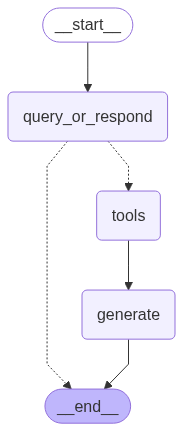

In [7]:
# Define schema for search
class Search(TypedDict):
    """Search query."""

    query: Annotated[str, ..., "Search query to run."]
    section: Annotated[
        Literal["beginning", "middle", "end"],
        ...,
        "Section to query.",
    ]

prompt = hub.pull("rlm/rag-prompt", api_url="https://api.smith.langchain.com")
# Define state for application
class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str


def analyze_query(state: State):
    structured_llm = llm.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    return {"query": query}
    

@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs


# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}


# Step 2: Execute the retrieval.
tools = ToolNode([retrieve])


# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer the question."
        "The content you are provided with are sermons preached by reverend William Marrion Branham,"
        "sometimes refered to as brother Branham or brother Bill."
        "If you don't know the answer, say that you "
        "don't know. Use five sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}


# graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
# graph_builder.add_edge(START, "analyze_query")
# graph = graph_builder.compile()

graph_builder = StateGraph(MessagesState)

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

# Specify an ID for the thread
config = {"configurable": {"thread_id": "abc123"}}

In [10]:
input_message = input("Enter your query (or 'stop' to exit): ").strip()
while input_message.lower() != "stop":
    try:
        for step in graph.stream(
            {"messages": [{"role": "user", "content": input_message}]},
            stream_mode="values",
            config=config,
        ):
            step["messages"][-1].pretty_print()
    except Exception as e:
        print(f"Error processing query: {e}")
    input_message = input("Enter your query (or 'stop' to exit): ").strip()


Enter your query (or 'stop' to exit):  Can you summarize the birth pain sermon for me?


================================ Human Message =================================

Can you summarize the birth pain sermon for me?
================================== Ai Message ==================================
Tool Calls:
  retrieve (199037a6-3d97-408c-b854-0eefa5f5ebf6)
 Call ID: 199037a6-3d97-408c-b854-0eefa5f5ebf6
  Args:
    query: summary of the birth pain sermon
================================= Tool Message =================================
Name: retrieve

Source: {'_id': '6877a40323ce00d6d2f9f261', 'source': '/Users/cdetcham/Projects/RAG/MessageSearchApp/data/65/65-0124 Birth Pains VGR.pdf', 'detection_class_prob': 0.6089565753936768, 'coordinates': {'points': [[90.61944444444444, 98.97449493408203], [90.61944444444444, 127.40795135498047], [252.24073791503906, 127.40795135498047], [252.24073791503906, 98.97449493408203]], 'system': 'PixelSpace', 'layout_width': 1088, 'layout_height': 1675}, 'last_modified': '2025-07-14T13:36:30', 'filetype': 'application/pdf', 'languages': ['

Enter your query (or 'stop' to exit):  What does bro Branham say about birth pains?


================================ Human Message =================================

What does bro Branham say about birth pains?
================================== Ai Message ==================================
Tool Calls:
  retrieve (5838d250-6eec-4a7a-8875-03d30c6d1758)
 Call ID: 5838d250-6eec-4a7a-8875-03d30c6d1758
  Args:
    query: What does bro Branham say about birth pains?
================================= Tool Message =================================
Name: retrieve

Source: {'_id': '6877a40323ce00d6d2f9f261', 'source': '/Users/cdetcham/Projects/RAG/MessageSearchApp/data/65/65-0124 Birth Pains VGR.pdf', 'detection_class_prob': 0.6089565753936768, 'coordinates': {'points': [[90.61944444444444, 98.97449493408203], [90.61944444444444, 127.40795135498047], [252.24073791503906, 127.40795135498047], [252.24073791503906, 98.97449493408203]], 'system': 'PixelSpace', 'layout_width': 1088, 'layout_height': 1675}, 'last_modified': '2025-07-14T13:36:30', 'filetype': 'application/pdf', 'langu

Enter your query (or 'stop' to exit):  stop
